# Kaggle Project

## Describe Your Dataset

**URL:** https://www.kaggle.com/datasets/sheshngupta/waldowilma

**Task:**

1. 커스텀 데이터셋의 구성과 활용
2. 데이터로더 정의
3. 이미지 출력상태 확인
4. CNN 모델 구성
5. 학습 진행
6. 평가 결과 확인

**Datasets**

백그라운드 이미지에 'Waldo' & 'Wilma' 이미지를 무작위 적용



**Features(x):**

Waldo & Wilma

**Target(y):**

Classification

---

# Code

### Library

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageEnhance
import os
import torch.nn as nn
import torch.optim as optim
import time
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

### Check image directory 

In [3]:
img_dir = 'C:/Users/ATRC/Desktop/finding_waldo'

bg_dir = img_dir +'/generated_images/wheres_wally.png'
waldo_dir = img_dir + '/generated_images/charecters/waldo.png'
wilma_dir = img_dir + '/generated_images/charecters/wilma.png'

### Show image

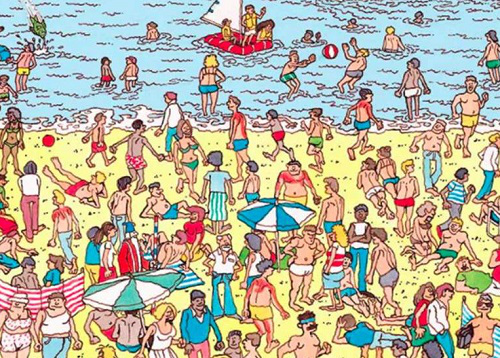

In [4]:
bg_img = Image.open(bg_dir)
bg_img

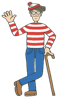

In [5]:
waldo_img = Image.open(waldo_dir)
waldo_img = waldo_img.resize((60, 100))
waldo_img

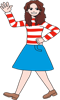

In [6]:
wilma_img = Image.open(wilma_dir)
wilma_img = wilma_img.resize((60, 100))
wilma_img

### Generate sample images

In [7]:
def generate_sample_image():
    
    # Background image
    bg_img = Image.open(bg_dir)
    bg_img = bg_img.resize((500, 350))
    
    # Waldo
    waldo_img = Image.open(waldo_dir)
    waldo_img = waldo_img.resize((60, 100))
    
    # Wilma
    wilma_img = Image.open(wilma_dir)
    wilma_img = wilma_img.resize((60, 100))
    
    # Waldo & Wilma 무작위 배치
    col = np.random.randint(0, 410)
    row = np.random.randint(0, 230)
    
    
    rand_person = np.random.choice([0, 1], p = [0.5, 0.5])
    
    if rand_person == 1:
        bg_img.paste(waldo_img, (col, row), mask = waldo_img)
        cat = 'Waldo'
        
    else:
        bg_img.paste(wilma_img, (col, row), mask = wilma_img)
        cat = 'Wilma'
        
    return np.array(bg_img), (col, row), rand_person, cat

### Test sample image

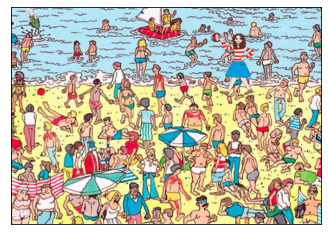

In [8]:
sample_img, pos, _, cat = generate_sample_image()
plt.imshow(sample_img)
plt.xticks([])
plt.yticks([])
plt.show()

### Bounding box

In [9]:
def plot_bbox(image, gt_coords, pred_coords = None):
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)
    draw.rectangle((gt_coords[0], gt_coords[1],gt_coords[0] + 60, gt_coords[1]+100), outline = 'green', width = 3)
    
    if pred_coords:
        draw.rectangle((pred_coords[0], pred_coords[1], pred_coords[0]+60, pred_coords[1] +100), outline= 'red', width=3)
        
    return image

### Test Bounding box

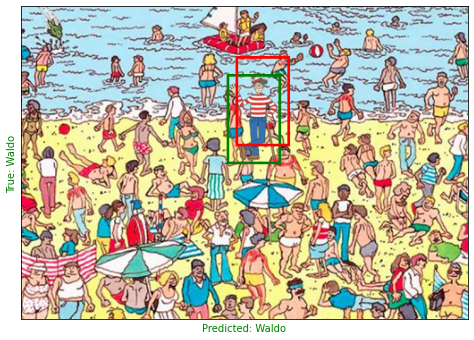

In [10]:
sample_img, pos, _, cat = generate_sample_image()

im = plot_bbox(sample_img, pos, (pos[0] + 10, pos[1] -20))

plt.figure(figsize = (8, 8))
plt.imshow(im)
plt.xticks([])
plt.yticks([])
plt.xlabel('Predicted: ' + cat, color = 'green')
plt.ylabel('True: ' + cat, color = 'green' )
plt.show()

### Dataset & Dataloader

In [11]:
class Waldo_Dataset(Dataset):
    def __init__(self, num_samples):
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # generate an example image
        sample_img, pos, person, _ = generate_sample_image()

        # put the images to the arrays
        x_batch = sample_img / 255  # normalize
        y_batch = person
        boundary_box = torch.tensor([pos[0], pos[1]])
        
        
 
        return {'image': torch.tensor(x_batch).cuda()}, {'class': torch.tensor(y_batch), 'box': boundary_box}


batch_size = 16
num_samples = 1000
dataset = Waldo_Dataset(num_samples)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### Model Construction (CNN)

In [12]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(32, 64, 6),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(64, 64, 6),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2)
            
        )
        
        self.regression = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*10*14, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 2)
        )
        
        self.classification = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*10*14, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.conv_layer(x)
        reg_out = self.regression(x)
        cla_out = self.classification(x)

        return reg_out, cla_out

### Model & Loss & Optimizer & Epochs

In [13]:
model = CNN().cuda()
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)
num_epochs = 10

### Train Model

In [14]:
for epoch in range(num_epochs):
    
    total_batch = len(dataset)
    
    for i, data in enumerate(dataloader):
        X = data[0]['image']
        X = X.permute(0, 3, 1, 2)
        X = X.float()
        
        Y = data[1]['class']
        
        pre = model(X)
        cost = loss(pre, Y)
        
          
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        
        if (i+1) % 100 == 0:    # print every 10 mini-batches
            print('Epoch [%d/%d], Iter [%d/%d], loss: %.4f' % (epoch + 1, num_epochs, i+1, total_batch, cost.item()))


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x29376 and 8960x1024)

---

## Performance

The results explains

....